# **Mô tả ngắn gọn: Áp dụng học máy để phân tích từ dữ liệu cũ của các ngân hàng, tính toán giá trị cổ phiếu và lãi suất, từ đó chọn ra ngân hàng phù hợp để đầu tư.**

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import pandas_profiling as pp
# plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.metrics import r2_score # mức độ phù hợp
from sklearn.metrics import mean_absolute_error # sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error # % sai số tuyệt đối trung bình

# I. Mount Google Drive

![](https://imgur.com/kpeMAsi.png)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/Colab Notebooks'
%cd {path}
!ls

/content/drive/MyDrive/Colab Notebooks
 A38146_NguyenMinhHieu_TestDatasets.ipynb
 A38843_BTVN_W2.ipynb
'A38971_Chu Tiến Thành_BtapW3.ipynb'
'A38971_Chu Tiến Thành_BT.ipynb'
'A38971_Chu Tiến Thành_Ex_W1 .ipynb'
 A38971_EDA.ipynb
 A38971-HomeWorkW6.ipynb
 A38971_KtraTKNC.ipynb
 A38971_W5_2.ipynb
 archive
 BRUH_Segmentations_Car222222222.ipynb
'BRUH: Segmentations Car.ipynb'
 BTVN_W2.ipynb
 Chapter4_Tuan_V2.ipynb
 Chapter6_PCA.ipynb
 Congculaptrinh_AI
'Copy of Lab2_iris_knn_dt.ipynb'
'Copy of  Lab5a. Support Vector Machines.ipynb'
'Copy of Lab5b.Ensemple .ipynb'
 Covid-19____.ipynb
 EDA_Stock.ipynb
 Ex_AI_W2.ipynb
 Ex_W3.ipynb
 Hoc_may.ipynb
 invest.ipynb
 khdl_gr5_stock.ipynb
 Lab1a.ipynb
 Mạng_NN_TF.ipynb
 PCA___.ipynb
 PCA_V2.ipynb
 seg_Hieu.ipynb
'stock (1).ipynb'
 stock-2.ipynb
 stock.ipynb
 stock_price.ipynb
 test02.ipynb
 testEx.ipynb
 test_PCA_V2.ipynb
 test_stock_price.ipynb
 TestW3.ipynb
 Untitled0.ipynb
 Untitled1.ipynb
 Untitled2.ipynb
 Untitled3.ipynb
 vnquant
 W1.i

# II. Cài đặt gói dữ liệu


In [3]:
# Mở comment khi chạy lần đầu

# !git clone https://github.com/phamdinhkhanh/vnquant
%cd vnquant
!python setup.py install

/content/drive/MyDrive/Colab Notebooks/vnquant
running install
running bdist_egg
running egg_info
writing vnquant.egg-info/PKG-INFO
writing dependency_links to vnquant.egg-info/dependency_links.txt
writing requirements to vnquant.egg-info/requires.txt
writing top-level names to vnquant.egg-info/top_level.txt
writing manifest file 'vnquant.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/vnquant
copying build/lib/vnquant/__version__.py -> build/bdist.linux-x86_64/egg/vnquant
copying build/lib/vnquant/__init__.py -> build/bdist.linux-x86_64/egg/vnquant
copying build/lib/vnquant/utils.py -> build/bdist.linux-x86_64/egg/vnquant
creating build/bdist.linux-x86_64/egg/vnquant/configs
copying build/lib/vnquant/configs/configs.py -> build/bdist.linux-x86_64/egg/vnquant/configs
copying build/lib/vnquant/configs/__init__.py -> build/bdist.linux-x86_64/egg/v

+ Test and import package

In [4]:
!pip freeze | grep vnquant
import vnquant
vnquant.__version__

vnquant==0.1.1


'0.1.1'

## Bảng dữ liệu về giá của từng mã cỗ phiếu

In [54]:
loader_acb = dt.DataLoader(symbols="ACB",
           start="2017-11-17",
           end="2022-11-16",
           minimal=True,
           data_source="cafe")

loader_bid = dt.DataLoader(symbols="BID",
           start="2017-11-17",
           end="2022-11-16",
           minimal=True,
           data_source="cafe")
loader_vcb = dt.DataLoader(symbols="VCB",
           start="2017-11-17",
           end="2022-11-16",
           minimal=True,
           data_source="cafe")

acb = loader_acb.download()
bid = loader_bid.download()
vcb = loader_vcb.download()

acb = pd.DataFrame(acb)
bid = pd.DataFrame(bid)
vcb = pd.DataFrame(vcb)

## Tạo bản báo cáo dữ liệu



In [9]:
import vnquant.data as dt
loader = dt.FinanceLoader('ACB', '2017-11-17','2022-11-16', minimal=True)
data_basic = loader.get_basic_index()
data_basic.head()

,2021-12,2020-12,2019-12,2018-12,2017-12
index,,,,,
Tăng trưởng Doanh thu thuần 4 quý liền kề so với cùng kỳ năm trước,0.299179,0.203924,0.168798,0.225257,0.227204
ROAE,0.238706,0.245650,0.249655,0.278995,0.141289
ROAA,0.020238,0.018914,0.017095,0.016719,0.008111
Tăng trưởng Vốn chủ sở hữu so với đầu năm,0.266664,0.276705,0.321034,0.311091,0.139954


## Vẽ biểu đồ



In [10]:
from vnquant import plot as pl
pl.vnquant_candle_stick(data='ACB',
                        title='ACB symbol from 2017-11-17 to 2022-11-16',
                        xlab='Date', ylab='Price',
                        start_date='2017-11-17',
                        end_date='2022-11-16',
                        show_advanced=['volume', 'macd', 'rsi'])

**RSI là tính toán tỉ lệ giữa mức tăng giá và giảm giá trung bình trong một khoảng thời gian nhất định, thể hiện tình trạng quá mua và quá bán của thị trường**

**MACD chỉ báo phản ánh biến động và cung cấp tín hiệu mua bán của thị trường**

## Dữ liệu các ngân hàng

In [11]:
from vnquant import utils
meta = utils.get_ind_class(code_list=["ACB"])
meta['data']

BASE_URL:  https://finfo-api.vndirect.com.vn/v4/industry_classification
payload_str:  q=codeList:ACB~industryCode:~industryLevel:~higherLevelCode:~englishName:~vietnameseName:&size=9999
header:  {'content-type': 'application/json', 'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.41 Safari/537.36'}


[{'industryCode': '8300',
  'industryLevel': '2',
  'higherLevelCode': '8000',
  'englishName': 'Banks',
  'vietnameseName': 'Ngân hàng',
  'totalCount': 27.0,
  'codeList': 'STB,LPB,BVB,MSB,VPB,TPB,MBB,BID,SGB,VCB,VAB,VIB,OCB,HDB,NVB,NAB,KLB,TCB,BAB,ABB,SSB,VBB,EIB,PGB,SHB,CTG,ACB'},
 {'industryCode': '8350',
  'industryLevel': '3',
  'higherLevelCode': '8300',
  'englishName': 'Banks',
  'vietnameseName': 'Ngân hàng',
  'totalCount': 27.0,
  'codeList': 'STB,LPB,BVB,MSB,VPB,TPB,MBB,BID,SGB,VCB,VAB,VIB,OCB,HDB,NVB,NAB,KLB,TCB,BAB,ABB,SSB,VBB,EIB,PGB,SHB,CTG,ACB'},
 {'industryCode': '8355',
  'industryLevel': '4',
  'higherLevelCode': '8350',
  'englishName': 'Banks',
  'vietnameseName': 'Ngân hàng',
  'totalCount': 27.0,
  'codeList': 'STB,LPB,BVB,MSB,VPB,TPB,MBB,BID,SGB,VCB,VAB,VIB,OCB,HDB,NVB,NAB,KLB,TCB,BAB,ABB,SSB,VBB,EIB,PGB,SHB,CTG,ACB'},
 {'industryCode': '8000',
  'industryLevel': '1',
  'englishName': 'FINANCIALS ',
  'vietnameseName': 'Tài chính',
  'totalCount': 238.0,
  'c

**Từ listbank ta chọn ra các ngân hàng mà ta muốn lấy dữ liệu rồi kết nối lại để phân tích, ở đây ta sẽ lấy ACB, BID và VCB**

In [58]:
list_banks = ['ACB','BID','VCB']
bank_stocks = pd.concat([acb,bid,vcb],axis=1, keys = list_banks)

bank_stocks.head()

ACB                                        BID                \
Attributes  high   low  open close adjust     volume   high    low   open   
Symbols      ACB   ACB   ACB   ACB    ACB        ACB    BID    BID    BID   
date                                                                        
2017-11-17  33.4  32.6  33.2  33.1   9.91  2308363.0  24.30  23.50  24.20   
2017-11-20  33.2  32.4  33.1  32.8   9.82  1424394.0  24.15  23.65  23.80   
2017-11-21  33.5  32.5  32.8  32.8   9.82  2009143.0  24.50  24.00  24.00   
2017-11-22  33.9  32.0  32.7  33.9  10.15  2937886.0  25.70  24.00  24.05   
2017-11-23  34.8  33.7  33.9  34.0  10.18  2520790.0  26.50  25.30  26.00   

                                       VCB                            \
Attributes  close adjust     volume   high    low  open close adjust   
Symbols       BID    BID        BID    VCB    VCB   VCB   VCB    VCB   
date                                                                   
2017-11-17  24.05  18.10  2818270.0  45.15  44.35  44.8  44.4  33.37   
2017-11-20  24.00  18.06  1514750.0  45.00  44.35  44.4  45.0  33.82   
2017-11-21  24.05  18.10  2397310.0  47.70  45.20  45.3  46.7  35.10   
2017-11-22  25.70  19.34  4341890.0  48.10  46.70  46.7  48.0  36.07   
2017-11-23  25.30  19.04  2648530.0  48.90  46.85  48.7  47.9  36.00   

                       
Attributes     volume  
Symbols           VCB  
date                   
2017-11-17  2413770.0  
2017-11-20  1783000.0  
2017-11-21  3950270.0  
2017-11-22  3416060.0  
2017-11-23  2846930.0

 **Vẽ biểu đồ giá cổ phiếu của các ngân hàng từ 17/11/2017 - 16/11/2022**

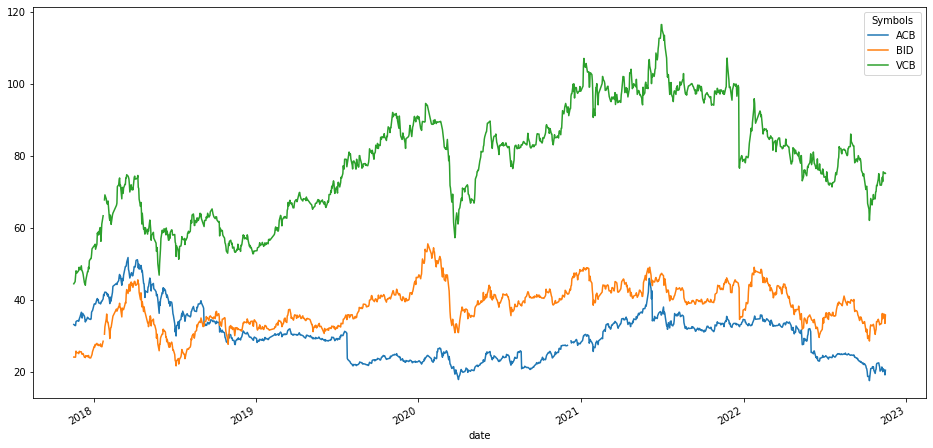

In [15]:
bank_stocks.xs(key='close',axis=1,level='Attributes').plot(figsize =(16, 8))

# VI. Phân tích định lượng

##Tính tỉ phần trăm suất lợi  nhuận của mỗi cổ phiếu hằng ngày

In [62]:
value_banks = pd.DataFrame()

for name in list_banks:
    value_banks[name] = bank_stocks[name]['close'].pct_change()*100 
                                                                      
value_banks.head()

,ACB,BID,VCB
date,,,
2017-11-17,NaN,NaN,NaN
2017-11-20,-0.906344,-0.207900,1.351351
2017-11-21,0.000000,0.208333,3.777778
2017-11-22,3.353659,6.860707,2.783726
2017-11-23,0.294985,-1.556420,-0.208333


**NX**: 

1. Giá trị lợi nhuận trong bảng: phần trăm dương là tỉ suất lợi nhuận tăng,phần trăm âm là tỉ suất lợu nhuận giảm

2. VD:  ['2017-11-20'] ACB tỉ suất lợi nhuận giảm -0.910%, BID giảm -0,208%, VCB tỉ suất lợi nhuận tăng 1.34%

3. Mỗi sàn có một khối lượng , giá đóng cửa của sàn ngày hôm trước sẽ là giá mở cửa của ngày hôm sau,giá trị tỉ suất lợi nhuận này tương ứng với giá trị đem lại lợi nhuận

## Thống kê mô tả

In [63]:
value_banks.describe()

,ACB,BID,VCB
count,1249.000000,1249.000000,1249.000000
mean,-0.008107,0.064960,0.063162
std,2.430251,2.569444,2.035532
min,-22.801303,-20.323326,-22.244692
25%,-0.909091,-1.027900,-0.976290
50%,0.000000,0.000000,0.000000
75%,1.003344,1.408451,1.033058
max,9.698997,6.997085,6.951027


## EDA (Exploratory Data Analysis)


## Ước lượng khoảng tin cậy

Đặt $r_t = \log(\frac{X_t}{X_{t-1}})$

$x_t = \frac{r_t-\bar{r}}{\sigma_{r}}$ sẽ theo sau với bậc $n-1$. 

In [64]:
import scipy.stats as st
for sym in list_banks:
  rt = value_banks[sym].dropna()
  interval = st.t.interval(alpha=0.95, df=value_banks.shape[0]-1,
                loc=np.mean(rt),
                scale=st.sem(rt))
  print('95% confidence interval of {} is {}'.format(sym, interval))

95% confidence interval of ACB is (-0.14301578597227405, 0.12680102708431817)
95% confidence interval of BID is (-0.07767549600958128, 0.207595117801885)
95% confidence interval of VCB is (-0.04983428320001934, 0.17615911966355965)


+ 95% giá trị khoảng tin cậy của ACB thuộc khoảng (-0.14, 0.12)
+ 95% giá trị khoảng tin cậy của BID thuộc khoảng (-0.07, 0.20)
+ 95% giá trị khoảng tin cậy của VCB thuộc khoảng (-0.04, 0.17)

## Làm sạch dữ liệu

In [112]:
bank_stocks.nunique()

     Attributes  Symbols
ACB  high        ACB         356
     low         ACB         345
     open        ACB         325
     close       ACB         354
     adjust      ACB         508
     volume      ACB        1243
BID  high        BID         405
     low         BID         408
     open        BID         382
     close       BID         409
     adjust      BID         630
     volume      BID        1245
VCB  high        VCB         452
     low         VCB         466
     open        VCB         454
     close       VCB         456
     adjust      VCB         648
     volume      VCB        1237
dtype: int64

In [113]:
bank_stocks.duplicated().sum()

0

In [116]:
bank_stocks.isnull().values.sum()

54

In [117]:
bank_stocks = bank_stocks.dropna()
bank_stocks.head()

ACB                                        BID                \
Attributes  high   low  open close adjust     volume   high    low   open   
Symbols      ACB   ACB   ACB   ACB    ACB        ACB    BID    BID    BID   
date                                                                        
2017-11-17  33.4  32.6  33.2  33.1   9.91  2308363.0  24.30  23.50  24.20   
2017-11-20  33.2  32.4  33.1  32.8   9.82  1424394.0  24.15  23.65  23.80   
2017-11-21  33.5  32.5  32.8  32.8   9.82  2009143.0  24.50  24.00  24.00   
2017-11-22  33.9  32.0  32.7  33.9  10.15  2937886.0  25.70  24.00  24.05   
2017-11-23  34.8  33.7  33.9  34.0  10.18  2520790.0  26.50  25.30  26.00   

                                       VCB                            \
Attributes  close adjust     volume   high    low  open close adjust   
Symbols       BID    BID        BID    VCB    VCB   VCB   VCB    VCB   
date                                                                   
2017-11-17  24.05  18.10  2818270.0  45.15  44.35  44.8  44.4  33.37   
2017-11-20  24.00  18.06  1514750.0  45.00  44.35  44.4  45.0  33.82   
2017-11-21  24.05  18.10  2397310.0  47.70  45.20  45.3  46.7  35.10   
2017-11-22  25.70  19.34  4341890.0  48.10  46.70  46.7  48.0  36.07   
2017-11-23  25.30  19.04  2648530.0  48.90  46.85  48.7  47.9  36.00   

                       
Attributes     volume  
Symbols           VCB  
date                   
2017-11-17  2413770.0  
2017-11-20  1783000.0  
2017-11-21  3950270.0  
2017-11-22  3416060.0  
2017-11-23  2846930.0

In [118]:
bank_stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1243 entries, 2017-11-17 to 2022-11-16
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (ACB, high, ACB)    1243 non-null   float64
 1   (ACB, low, ACB)     1243 non-null   float64
 2   (ACB, open, ACB)    1243 non-null   float64
 3   (ACB, close, ACB)   1243 non-null   float64
 4   (ACB, adjust, ACB)  1243 non-null   float64
 5   (ACB, volume, ACB)  1243 non-null   float64
 6   (BID, high, BID)    1243 non-null   float64
 7   (BID, low, BID)     1243 non-null   float64
 8   (BID, open, BID)    1243 non-null   float64
 9   (BID, close, BID)   1243 non-null   float64
 10  (BID, adjust, BID)  1243 non-null   float64
 11  (BID, volume, BID)  1243 non-null   float64
 12  (VCB, high, VCB)    1243 non-null   float64
 13  (VCB, low, VCB)     1243 non-null   float64
 14  (VCB, open, VCB)    1243 non-null   float64
 15  (VCB, close, VCB)   1243 non-null   f

**Không có dữ liệu trùng lặp, một số dữ liệu bị không đồng bộ trong quá trình concat, do dữ liệu khuyết thiếu ít và tập trung trong một hàng nhất định => Xử lý bằng cách xóa những hàng có giá trị khuyết thiếu**

## Các loại biểu đồ

In [78]:
!pip install cufflinks
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [80]:
import cufflinks as cf
cf.go_offline()
import plotly.io as pio 
pio.renderers.default = "colab"

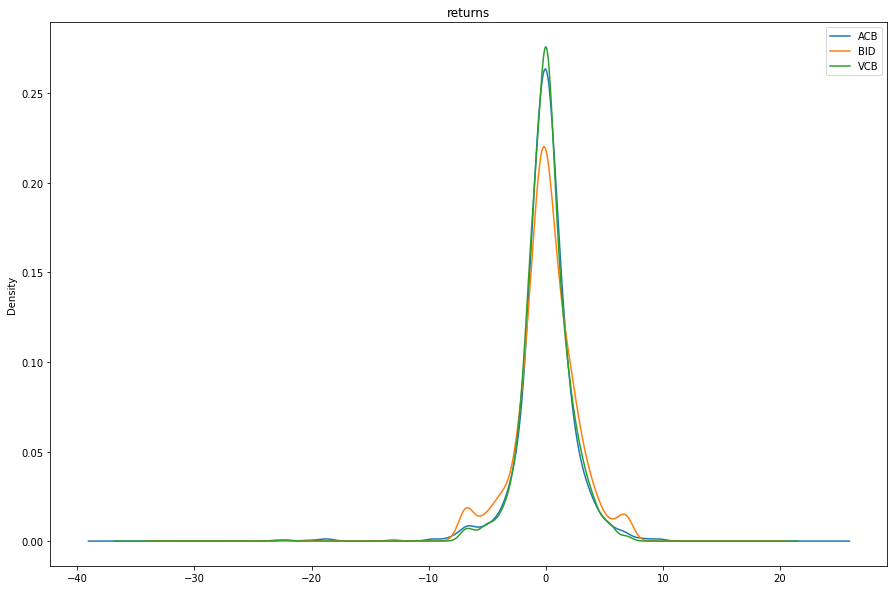

In [65]:
value_banks['ACB'].plot(kind='kde', label='ACB', figsize=(15,10), title='returns')
value_banks['BID'].plot(kind='kde', label='BID')
value_banks['VCB'].plot(kind='kde', label='VCB')
plt.legend()

**NX:** Biểu đồ 

1.   BID có thanh khoản thấp nhất trong 3 mã cổ phiếu -> rủi ro cao

2.   VCB có thanh khoản cao nhất -> giá cổ phiếu sẽ ít bị ảnh hưởng, rủi ro thấp

In [66]:
value_banks.std()

ACB    2.430251
BID    2.569444
VCB    2.035532
dtype: float64

**NX:** + Độ lệch chuẩn giúp xác định biến động thị trường so với giá trung bình của cổ phiếu.

        +Khi giá di chuyển mạnh, độ lệch chuẩn cao, nghĩa là một khoản đầu tư sẽ có rủi ro

        + Ta thấy: 
1. BID có độ lệch chuẩn cao nhất 2.5694 -> rủi ro cao nhất
2. VCB có độ lệch chuẩn thấp nhất 2.035 -> rủi ro thấp nhất 

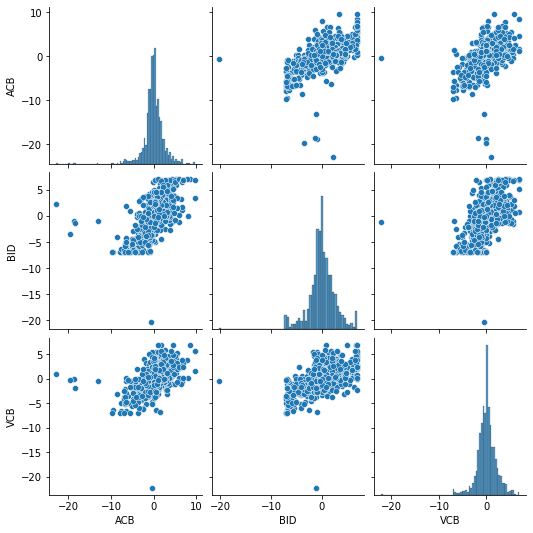

In [67]:
# Dùng Seaborn Sử dụng biểu đồ pairplot để tìm cổ phiếu nổi bật dựa trên giá trị lợi nhuận

import seaborn as sns
sns.pairplot(value_banks)

**NX:** Sử dụng Seaborn trả về biểu đồ phân tán các giá trị trong ngày, phần trăm lợi nhuận càng cao thì biểu đồ càng nổi bật hơn.

Biểu đồ Seaborn cho ta hình dung số liệu cổ phiếu để phân tích. Các giá trị âm, các giá trị dương, giá trị cao nhất trong khoảng:

+ Giá trị âm ACB phân tán trong khoảng [-10,-20], BID và VCB trong khoảng -20

+ Giá trị dương ACB nằm trong khoảng [-10,10], BID và VCB nằm trong khoảng [-5,5] có mật độ tập trung cao 



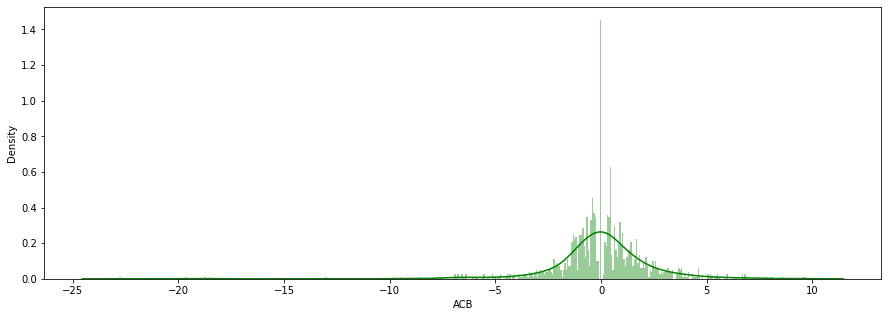

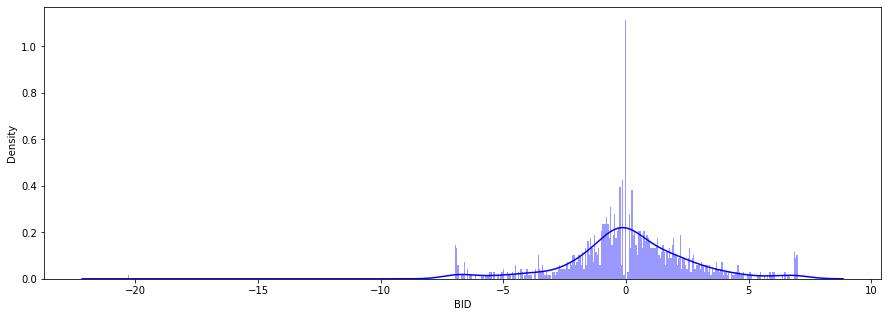

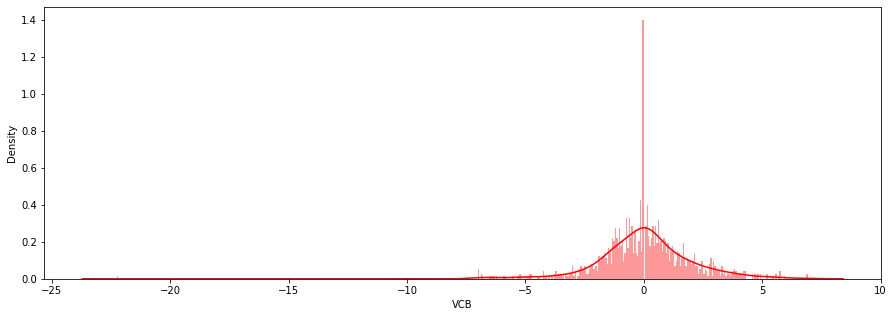

In [69]:
plt.figure(figsize=(15,5))
sns.distplot(value_banks.loc['2017-11-17':'2022-11-16']['ACB'],color='green',bins=500)

plt.figure(figsize=(15,5))
sns.distplot(value_banks.loc['2017-11-17':'2022-11-16']['BID'],color='blue',bins=500)

plt.figure(figsize=(15,5))
sns.distplot(value_banks.loc['2017-11-17':'2022-11-16']['VCB'],color='red',bins=500)

**NX:** 

        +Phầm trăm lợi nhuận từ -10 rất hạn chế

        +Biên độ Dao động tập trung trong khoảng khoảng [-2.5,2.5] -> phần trăm lợi nhuận ACB nằm chủ yếu ở vùng này

        +BID và VCB [-10,-5) có ít các dao dịch phần trăm lợi nhuận thấp

        +Khối lượng lớn các giao dịch trong khoảng (-2.5,2.5)->phần trăm lợi nhuận cao tập trung ở đây

In [70]:
value_banks.corr()

,ACB,BID,VCB
ACB,1.000000,0.570407,0.476825
BID,0.570407,1.000000,0.551712
VCB,0.476825,0.551712,1.000000


**Sử dụng bản đồ nhiệt để trực quan hóa phạm vi tương quan giữa các cổ phiếu cạnh tranh (màu sắc hơn, hai cổ phiếu càng tương quan)**

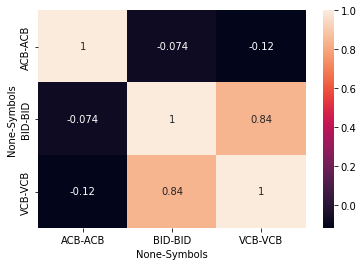

In [72]:
sns.heatmap(bank_stocks.xs(key='close',axis=1,level='Attributes').corr(),annot=True)

**NX:** 

+ Biểu đồ nhiệt thể hiện mối tương quan của các cổ phiếu dựa trên biểu đồ ma trận, hàm corr sẽ lấy ra hệ số tương quan. 

+ Hệ số tương quan sẽ lấy giá trị từ (-1,1), thường sẽ sử dụng hệ số tương quan cao 0.8 hoặc 0.9 khi đó cổ phiếu có sự tương quan với nhau VD: VCB BID có độ tương quan 0.84 thì có nghĩa VCB tăng thì BID cũng tăng 

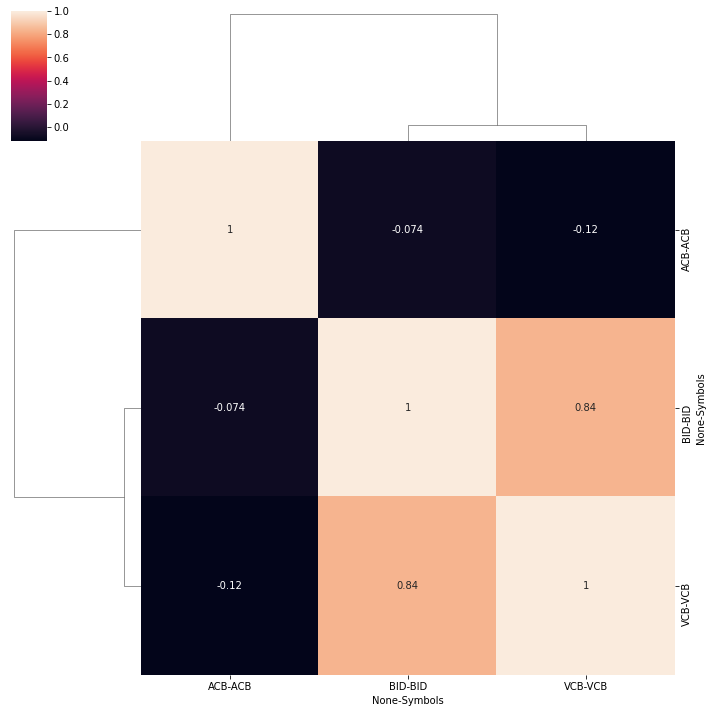

In [73]:
#CLUSTERMAP của Seaborn để phân cụm các mối tương quan với nhau:
sns.clustermap(bank_stocks.xs(key='close',axis=1,level='Attributes').corr(),annot=True)

In [81]:
bank_stocks.xs(key='close',axis=1,level='Attributes').iplot(title = "Giá đóng cửa", xTitle = "Năm", yTitle = "Giá")

In [85]:
acb['close'].loc['2017-11-17':'2022-11-16'].ta_plot(study='sma',periods=30,title='SMA ACB')
bid['close'].loc['2017-11-17':'2022-11-16'].ta_plot(study='sma',periods=30,title='SMA BID')
vcb['close'].loc['2017-11-17':'2022-11-16'].ta_plot(study='sma',periods=30,title='SMA VCB')


**NX:** 
        
        + Đường trung bình động, thể hiện biến động, chỉ báo xu hướng của giá cổ phiếu trong một khoảng thời gian

        + Mục đích: theo dõi giá đang vận động theo xu hướng tăng hoặc giảm hay không có xu hướng

        + Biểu đồ cho thấy:
        
        - ACB,VCB đang trong xu hướng giảm
        
        - BID có biến động liên tục trong khoảng thời gian 2020 đến nay
        -> không có xu hướng cụ thể. Nhưng có thể thấy giai đoạn cuối 2022 có sự phục hồi giá trở lại


In [119]:
acb['close'].loc['2017-11-17':'2022-11-16'].ta_plot(study='boll')
bid['close'].loc['2017-11-17':'2022-11-16'].ta_plot(study='boll')
vcb['close'].loc['2017-11-17':'2022-11-16'].ta_plot(study='boll')

**NX:**
    
- Bollinger Band là chỉ báo được kết hợp bởi đường trung bình MA với độ lệch chuẩn. Chỉ báo này được cấu tạo bởi 3 thành phần chính:

        -Dải trên (Upper Band): là dải giữa cộng với 2 độ lệch chuẩn. 

        -Dải giữa (Middle Band): là đường trung bình động SMA 20.

        -Dải dưới (Lower Band): là dải giữa trừ đi 2 độ lệch chuẩn. 
- Chúng ta có thể dễ dàng xác định được điểm break out cũng như giai đoạn tài sản có sự biến động thấp với mức độ tối thiểu để thấy được tín hiệu hoàn hảo cho sự quay trở lại của mức độ biến động mạnh trong thời gian nào và đâu là thời điểm tiềm năng để các nhà đầu tư vào lệnh và nắm bắt cơ hội kiếm lời.

## Training model

## Đọc dữ liệu và tiền sử lý dữ liệu

In [88]:
acb.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1245 entries, 2017-11-17 to 2022-11-16
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (high, ACB)    1245 non-null   float64
 1   (low, ACB)     1245 non-null   float64
 2   (open, ACB)    1245 non-null   float64
 3   (close, ACB)   1245 non-null   float64
 4   (adjust, ACB)  1245 non-null   float64
 5   (volume, ACB)  1245 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 100.4 KB


In [122]:
data = acb['close']
data

Symbols,ACB
date,
2017-11-17,33.1
2017-11-20,32.8
2017-11-21,32.8
2017-11-22,33.9
2017-11-23,34.0
...,...
2022-11-10,20.0
2022-11-11,20.8
2022-11-14,20.3


In [91]:
dataset = data.values
training_data_len = int(np.ceil(len(dataset) * .80 )) # chia dữ liệu train(80%)
print("{},{}".format(len(data), training_data_len))

1245,996


In [92]:
# Sử dụng MinMaxScaler để chuẩn hóa tất cả dữ liệu chứng khoán thành từ 0 đến 1 và định hình lại dữ liệu chuẩn hóa thành một mảng hai chiều.
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset.reshape(-1,1))
scaled_data

array([[0.45614035],
       [0.44736842],
       [0.44736842],
       ...,
       [0.08187135],
       [0.04678363],
       [0.08479532]])

In [98]:
train_data = scaled_data[0:int(training_data_len), :]
test_data = scaled_data[training_data_len - 50:, :]
# Khởi tạo dữ liệu train và test với ý tưởng sử dụng giá của 50 ngày liên tục làm cơ sở để dự đoán cho giá của ngày tiếp theo
def get_data(): 
    x_train, y_train, x_test, y_test = [], [], [], dataset[training_data_len:, :] #trong đó y_test là giá thực 
    for i in range(50, len(train_data)):
        x_train.append(train_data[i-50:i, :]) # list danh sách các mảng, mỗi mảng bao gồm giá đóng cửa liên tục của 50 ngày
        y_train.append(train_data[i, :]) # list danh sách giá đóng cửa của ngày hôm sau tương ứng với mỗi mảng của x_train
            
    [x_test.append(test_data[i-50:i, :]) for i in range(50, len(test_data))] # list danh sách các mảng, mỗi mảng bao gồm giá đóng cửa liên tục của 50 ngày
    
    x_train, y_train, x_test = np.array(x_train), np.array(y_train), np.array(x_test) # chuyển đổi feature data(x_train, x_test) và label data(y_train, y_test) thành mảng numpy vì nó là định dạng dữ liệu được TF chấp nhận khi đào tạo mô hình NN

    return x_train, y_train, x_test, y_test

print('Train_data: {} \n Test_data:{}'.format(train_data.shape,test_data.shape))

Train_data: (996, 1) 
 Test_data:(299, 1)


## Xây dựng mô hình

In [99]:
def get_model(x_train, y_train):
    inputs = keras.layers.Input((x_train.shape[1], 1), name='input') # Khởi tạo một tensor của TF và xác định kích cỡ đầu vào của mô hình 

    x = keras.layers.LSTM(128, return_sequences=True)(inputs) # Thêm một lớp LSTM với 128 network units và đặt return_sequences=True để đầu ra của lớp này sẽ là một chuỗi khác có cùng độ dài
    x = keras.layers.LSTM(64)(x) # Thêm một lớp LSTM khác với 64 network units nhưng để mặc định return_sequences=False để chỉ trả về kết quả cuối cùng trong chuỗi đầu ra
    x = keras.layers.Dropout(0.25)(x) # Thêm lớp Dropout giúp bỏ qua một số units trong quá trình huấn luyện một cách ngẫu nhiên, tránh mô hình overfit
    x = keras.layers.Dense(25)(x) # Thêm một lớp Dense với 25 network unit giúp kết nối mỗi nốt của layer này với mọi nốt của layer trước
    x = keras.layers.Dropout(0.25)(x)

    outputs = keras.layers.Dense(1)(x) # Cuối cùng thêm một lớp Dense và chỉ định là đầu ra của 1 đơn vị mạng 
    model = keras.Model(inputs = inputs, outputs = outputs) # Cấu hình mô hình từ inputs tensor và outputs tensor
    
    return model

In [100]:
x_train, y_train, x_test, y_test = get_data()

In [101]:
model = get_model(x_train, y_train)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 50, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 50, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 26    

In [102]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss='mse',metrics='mse') #biên dịch mô hình bằng cách thiết lập trình tối ưu hóa adam với learning_rate=0,0001 và đặt sai số bình phương trung bình làm hàm mất mát
model.fit(x_train, y_train, batch_size=1, epochs=10) # Huấn luyện mô hình bằng cách fit với training set, thử với batch size 1 và chạy đào tạo với 10 epoch

Epoch 1/10
946/946 [==============================] - 34s 31ms/step - loss: 0.0133 - mse: 0.0133
Epoch 2/10
946/946 [==============================] - 33s 35ms/step - loss: 0.0087 - mse: 0.0087
Epoch 3/10
946/946 [==============================] - 29s 31ms/step - loss: 0.0076 - mse: 0.0076
Epoch 4/10
946/946 [==============================] - 30s 32ms/step - loss: 0.0070 - mse: 0.0070
Epoch 5/10
946/946 [==============================] - 29s 31ms/step - loss: 0.0062 - mse: 0.0062
Epoch 6/10
946/946 [==============================] - 30s 31ms/step - loss: 0.0058 - mse: 0.0058
Epoch 7/10
946/946 [==============================] - 30s 31ms/step - loss: 0.0050 - mse: 0.0050
Epoch 8/10
946/946 [==============================] - 34s 36ms/step - loss: 0.0049 - mse: 0.0049
Epoch 9/10
946/946 [==============================] - 36s 38ms/step - loss: 0.0046 - mse: 0.0046
Epoch 10/10
946/946 [==============================] - 37s 39ms/step - loss: 0.0045 - mse: 0.0045


## Áp dụng mô hình để dự đoán giá cổ phiếu

In [103]:
predictions = model.predict(x_test) # Áp dụng mô hình để dự đoán giá cổ phiếu dựa trên bộ thử nghiệm.
predictions = scaler.inverse_transform(predictions) # Chuẩn hóa lại dữ liệu về định dạng giá trị gốc do dữ liệu đang được chuẩn hóa từ 0-1

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2))) # Áp dụng công thức RMSE để tính mức độ chênh lệch giữa giá dự đoán và giá thực (y_test)
rmse

8/8 [==============================] - 1s 40ms/step


1.124925880073937

In [104]:
print(r2_score(y_test, predictions))
print(mean_absolute_error(y_test, predictions))
print(mean_absolute_percentage_error(y_test, predictions))

0.9523098613908826
0.7847258403119313
0.03007224396660218


In [105]:
# Chia dữ liệu chứng khoán thành 3 khu vực biểu đồ: train, val, pred
l1_train = data[:training_data_len]
l2_valid = data[training_data_len:]
l2_valid['Predictions'] = predictions

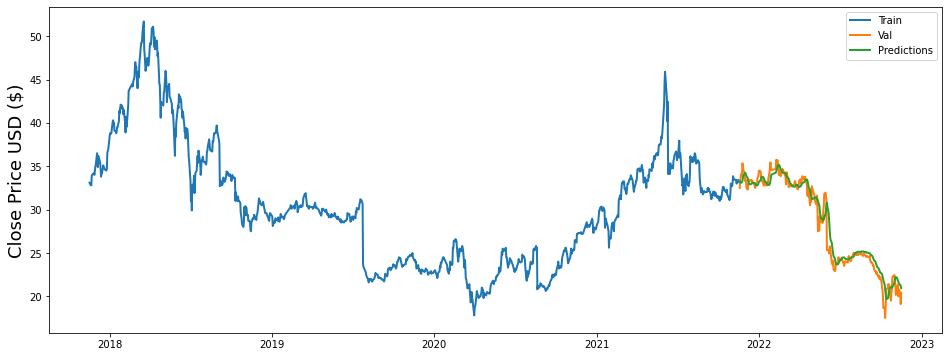

In [106]:
def get_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(16,6))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Close Price USD ($)', fontsize=18)
    ax.set_title(title)
    ax.legend(['Train', 'Val', 'Predictions'], loc='upper right')

get_plot(l1_train, l2_valid)

In [107]:
l2_valid

Symbols,ACB,Predictions
date,,
2021-11-18,32.50,33.236736
2021-11-19,33.45,33.127869
2021-11-22,34.15,33.094669
2021-11-23,33.95,33.183510
2021-11-24,35.35,33.304337
...,...,...
2022-11-10,20.00,21.649288
2022-11-11,20.80,21.449554
2022-11-14,20.30,21.315836


### Dự đoán giá cổ phiếu ACB trong ngày tiếp theo

In [108]:
real_data = [test_data[len(test_data) + 1 - 90: len(test_data + 1), :]]
real_data = np.array(real_data)
real_data.shape

(1, 89, 1)

In [109]:
next_pred = model.predict(real_data)
next_pred = scaler.inverse_transform(next_pred)
print("Pred next day: {}".format(next_pred))

1/1 [==============================] - 1s 913ms/step
Pred next day: [[20.793335]]


## Kết luận:
- Kết quả từ việc so sánh phân tích lãi suất và cổ phiếu trên là dành cho những sinh viên muốn tìm hiểu và luyện tập phân tích khoa học dữ liệu, giúp người dùng có cái nhìn tổng thể và chi tiết nhất, qua đó hiểu và có thể xây dựng các mô hình tương tự một cách trực quan hơn.
-	Định hướng và phát triển tương lai:
Trong tương lai, mong muốn xây dựng được một mô hình dự đoán thực sự, có thể áp dụng được vào trong thực tế. 
